In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # for data agmuntation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
import glob
import matplotlib.pyplot as plt

2025-04-26 19:48:51.632075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 19:48:51.640864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745677131.651283   21374 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745677131.654325   21374 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745677131.662034   21374 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Define paths for training and validation
train_dir = r"Plant_Disease_Dataset/New Plant Diseases Dataset(Augmented)/train"
valid_dir = r"Plant_Disease_Dataset/New Plant Diseases Dataset(Augmented)/valid"
test_dir = r"Plant_Disease_Dataset/New Plant Diseases Dataset(Augmented)/test"
# Image size and batch size
image_size = (128, 128)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 18504 images belonging to 10 classes.
Found 4626 images belonging to 10 classes.


In [9]:
# Define test directory
# test_dir = r"C:\XPrathmesh\College Stuff\DeepLearning\test\test"

# Get all test image paths
test_image_paths = glob.glob(test_dir + "/*.JPG")

# Preprocess test images
test_images = []
for img_path in test_image_paths:
    img = load_img(img_path)  # Resize images to (128, 128)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    test_images.append(img_array)

test_images = np.array(test_images)  # Convert to NumPy array
print(f"Loaded {len(test_images)} test images.")


Loaded 33 test images.


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=2,
    callbacks=[early_stopping]
)



579/579 ━━━━━━━━━━━━━━━━━━━━ 175s 301ms/step - accuracy: 0.5396 - loss: 1.3633 - val_accuracy: 0.8694 - val_loss: 0.3589


In [13]:
model.save('plant_disease_model.h5')

In [14]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(valid_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


145/145 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8708 - loss: 0.3543
Validation Loss: 0.3589
Validation Accuracy: 0.8694


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


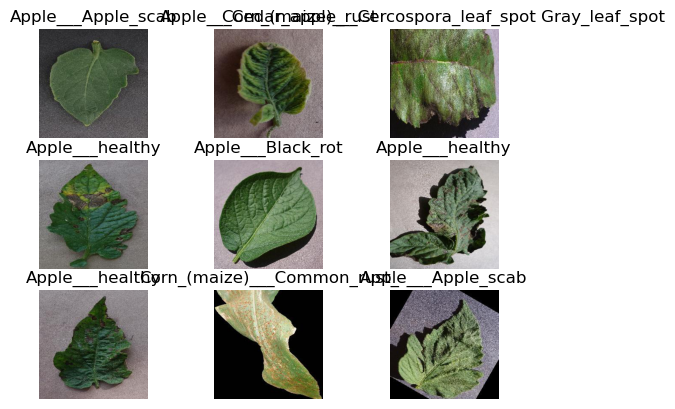

In [8]:
# Predict on test images
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to class labels
class_labels = list(train_data.class_indices.keys())
predicted_labels = [class_labels[k] for k in predicted_classes]

# Display some test results
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(test_image_paths[i]))
    plt.title(predicted_labels[i])
    plt.axis('off')
plt.show()


In [10]:
# Save the model
model.save("plant_disease_model.h5")

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Ensure test_images is a list of image paths
# if isinstance(test_images, list):  
#     test_images_array = np.array([
#         img_to_array(l0oad_img(img_path, target_size=(img_height, img_width))) for img_path in test_images
#     ])
#     test_images_array = test_images_array / 255.0  # Normalize pixel values
# else:
#     test_images_array = test_images  # Use as-is if already a NumPy array

# # Ensure correct shape for model prediction
# if len(test_images_array.shape) == 3:  
#     test_images_array = np.expand_dims(test_images_array, axis=0)

# # Predict on test images
# predictions = model.predict(test_images_array)
# predicted_classes = np.argmax(predictions, axis=1)

# # Map predictions to class labels
# class_labels = list(train_data.class_indices.keys())

# # Ensure class mapping is within range
# predicted_labels = [class_labels[k] if k < len(class_labels) else "Unknown" for k in predicted_classes]

# # Display some test results
# plt.figure(figsize=(9, 9))
# for i in range(min(9, len(test_images))):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(plt.imread(test_images[i]))
#     plt.title(predicted_labels[i])
#     plt.axis('off')

# plt.show()
